In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE 
from os import path
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
from wordcloud import ImageColorGenerator
import re

import pickle
import joblib
import spacy

import re
import nltk
from nltk.corpus import stopwords
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
#nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import warnings
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from gensim.models import CoherenceModel
from gensim import corpora, models
#from pyLDAvis import gensim

Using TensorFlow backend.


In [2]:
tweets = pd.read_csv("/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/Tweets2.csv")

In [4]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,NaN,Pacific Time (US & Canada)


In [4]:
tweets.airline_sentiment.value_counts()/len(tweets)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

# Positive vs Negative Sentiment Categories Using LDA

In [4]:
pos = tweets[tweets.airline_sentiment == 'positive']
neg = tweets[tweets.airline_sentiment == 'negative']
neu = tweets[tweets.airline_sentiment == 'neutral']

In [5]:
neg = neg.reset_index(drop=True)

### negative tweets categories - overall

In [34]:
text = neg.text.dropna()
text = text.to_string().lower()
print("There are {} wor ds in the combination of all review.".format(len(text)))

There are 532323 wor ds in the combination of all review.


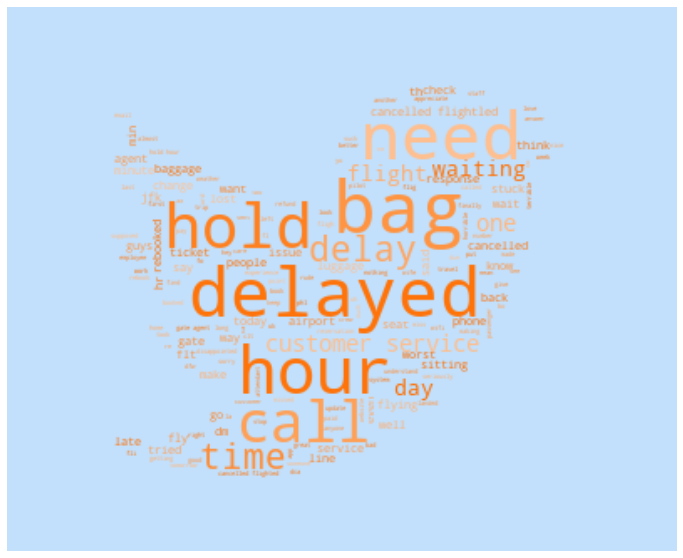

In [34]:
np.random.seed(123)
char_mask = np.array(Image.open("/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/tweey.png"))


def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(26,100%%, %d%%)" % np.random.randint(50,80))

    
transformed_mask = np.ndarray((char_mask.shape[0],char_mask.shape[1]), np.int32)
for i in range(len(char_mask)):
    transformed_mask[i] = list(map(transform_format, char_mask[i]))
    
    
stopwords = set(STOPWORDS)
stopwords.update(["american", "air","airline","thank","united","us","airways","virgin","america","jetblue",
                 "usairway","usairways","flight","americanair","southwestair","southwestairlines",
                 "southwestairway","southwestairways","virginamerica","really","will","going","thanks","thankyou",
                 "please","got","let","take","help","already","never","now","told","guy","new","sure","still","amp",
                 "plane","tell","ye","trying","yes"])

textwc = WordCloud(stopwords=stopwords,mask=transformed_mask, max_words=200,random_state=1,background_color="#c2e0fc").generate(text)
plt.figure(figsize=[20,10])
plt.imshow(textwc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/wcneg.png',transparent=True)
plt.show()

# LDA Model

<u>References:</u>
- https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05
- http://blog.echen.me/2012/03/20/infinite-mixture-models-with-nonparametric-bayes-and-the-dirichlet-process/
- https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
- https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

1. Dimensionality Reduction <br>
where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}.
2. Unsupervised Learning <br>
where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight.
3. Tagging <br>
abstract “topics” that occur in a collection of documents that best represents the information in them.

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:
psi, the distribution of words for each topic K
phi, the distribution of topics for each document i



### Parameters of LDA
* **Alpha** parameter is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
* **Beta** parameter is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

# LDA Model to Find Topics for Negative Reviews

In [8]:
#getting the adjectives and conjuction using spacy
doc = []
t = []
for row in range(len(neg.text)):
    doc.append(nlp(neg.text[row]))
    t.append([str(token) for token in doc[row] if (token.pos_ in ["ADJ","CCONJ"])])

In [160]:
ts = set()
for i in range(len(t)):
    ts.add(i)

In [8]:
#cities = pd.read_csv("https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv",sep="|")
#cities = cities.iloc[:,:2]
#cities.drop_duplicates(keep='first',inplace=True)

#preprocess data
def preprocess(text):
    stopwords = set(STOPWORDS)
    stopwords.update(["american", "air","airline","thank","united","us","airways","virgin","america","jetblue","youre","extremely",
                     "usairway","usairways","flight","americanair","southwestair","southwestairlines","arbitrarily","dream","crazy",
                     "southwestairway","southwestairways","virginamerica","really","will","going","thanks","thankyou","passengersdont",
                     "please","got","let","take","help","already","never","now","told","guy","new","sure","still","amp","continue",
                     "plane","tell","ye","trying","yes","guy","much","appreciate", "thx","back","ok","good","credit","aacom",
                     "flying","love","great","awesome","see","nice","alway","httptcojwl26g6lrw","dontflythem","motherinlaw","night",
                     "nogearnotraining","seriously","didnt","coudnt","cant","wont","dont","wat","buffaloniagara","hasshe","morning",
                     "woulda","people","try","youve","youd","yours","flightled","tomorrow","today","wat","jfkyou","flite","cause",
                     "flightr","flight","need","hours","nooooo","like","doesnt","right","talk","tweet","mention","pbijfk","ridiculuous",
                     "wasnt","suppose","want","understand","come","work","worse","treat","think","know","worst","paulo","staduim",
                     "wouldnt","stay","away","wont","werent","happen","sorry","havent","tonight","drive","life","thing","aa951",
                     "whats","theyre","better","thats","allow","hope","stop","cool","niece","happy","word","customercant",
                     "suck","sunday","monday","tuesday","wednesday","thursday","friday","saturday","weekend","ruin","shouldnt",
                     "miami","los angeles","new york","chicago","dallas","apparently","itover","someones","savannah","lucymay",
                     "betterother","instead","look","hopefully","yesterday","antonio","unacceptable","folks","record",'arent',
                     "miss","hang","wrong","stick","grind","tarmac","theres","forget","terrible","clothe","terrible","break",
                     "actually","frustrate","correct","ridiculous","expect","different","pathetic","bother","follow","fault",
                     "impossible","point","cover","person","ask","speak","things","earlier","mean","select","minutes",
                     "unite","horrible","country","leave","speak","apologize","faster","hop","confuse","lose","flightd","hear",
                     "literally","years","surprise","bump","fail","compensate","hand","helpful","upset","friend","excuse","claim",
                     "situation","multiple","weather","choose","company","believe","question","kick","anymore","awful","delta",
                      "dozen","medical","completely","finally", "waste","shock","annoy","maybe","strand","mess","finally",
                      "plan","place","apology","center","plan","twitter","promise","prefer","count","maybe","shock","longer","meet",
                         "important","drop"])
 
    #stopwords.update([i for i in ts])
    # stopwords.update([str(i).lower() for i in cities.City]) #removing City names in US
    r = re.compile(r'(?<=\@)(\w+)') #remove words after tags --> usually twitter account
    ra = re.compile(r'(?<=\#)(\w+)') #remove words after hashtags
    ro = re.compile(r'(flt\d*)') #remove words after flight number
    names = r.findall(text.lower())
    hashtag = ra.findall(text.lower())
    flight = ro.findall(text.lower())
    lmtzr = WordNetLemmatizer()
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lmtzr.lemmatize(item,'v'))
        return lemmatized
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    #doc = nlp(text)
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    tokens = [ch for ch in tokens if len(ch)>4] #remove words with character length below 2
    tokens = [ch for ch in tokens if len(ch)<=15] #remove words with character length above 15 
    lemm = stem_tokens(tokens, lmtzr)
    lemstop = [i for i in lemm if i not in stopwords]
    lemstopcl = [i for i in lemstop if i not in names]
    lemstopcl = [i for i in lemstopcl if i not in hashtag]
    lemstopcl = [i for i in lemstopcl if i not in flight]
    lemstopcl = [i for i in lemstopcl if not i.isdigit()]
    #lemstopcl1 = [i for i in lemstopcl if i not in t]
    return lemstopcl


In [178]:
#testing the tokenizer
text = """@Jenny @Joe and @Susan we are all very dissapointing in your service with the LONG delays
            for flt15539 560948 #notdoingthisanymore #dontflythem in New York to Chicago"""
preprocess(text)

['dissapointing', 'service', 'delay']

In [179]:
%%time
import warnings
warnings.simplefilter('ignore')

neg['token']=neg.text.map(preprocess)

CPU times: user 4.61 s, sys: 167 ms, total: 4.77 s
Wall time: 4.89 s


In [180]:
processed_docs=neg['token']
id2word = gensim.corpora.Dictionary(processed_docs)
corpus = [id2word.doc2bow(text) for text in processed_docs]


In [181]:
id2word.save_as_text('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/dict.txt')
id2word.save('id2word.dict')

### Parameters
- **corpus** ({iterable of list of (int, float), scipy.sparse.csc}, optional) – Stream of document vectors or sparse matrix of shape (num_terms, num_documents). If not given, the model is left untrained (presumably because you want to call update() manually).

- **num_topics** (int, optional) – The number of requested latent topics to be extracted from the training corpus.

- **id2word** ({dict of (int, str), gensim.corpora.dictionary.Dictionary}) – Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.

- **distributed** (bool, optional) – Whether distributed computing should be used to accelerate training.

- **chunksize** (int, optional) – Number of documents to be used in each training chunk.

- **passes** (int, optional) – Number of passes through the corpus during training.

- **alpha** ({numpy.ndarray, str}, optional) –

Can be set to an 1D array of length equal to the number of expected topics that expresses our a-priori belief for the each topics’ probability. Alternatively default prior selecting strategies can be employed by supplying a string:

’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / topicno.

’auto’: Learns an asymmetric prior from the corpus (not available if distributed==True).

- **eta** ({float, np.array, str}, optional) –

A-priori belief on word probability, this can be:

scalar for a symmetric prior over topic/word probability,

vector of length num_words to denote an asymmetric user defined probability for each word,

matrix of shape (num_topics, num_words) to assign a probability for each word-topic combination,

the string ‘auto’ to learn the asymmetric prior from the data.



In [129]:
def compute_coherence_values(dictionary, corpus, texts, start, stop):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics,
                                                id2word=id2word,
                                               random_state=123,
                                               alpha='auto',
                                                eta='auto',
                                               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [130]:
start=3
stop=9
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=processed_docs,
                                                        start=start, 
                                                        stop=stop)

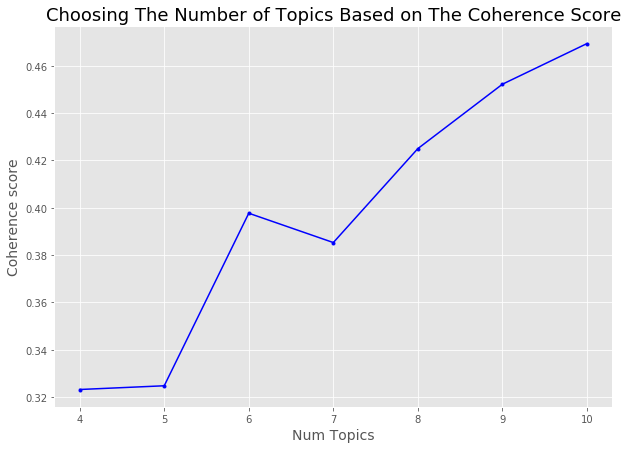

In [131]:
x = range(start, stop)
plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.plot(x, coherence_values, color = "blue",marker=".")
plt.xlabel("Num Topics", size=14)
plt.ylabel("Coherence score", size=14)
plt.title('Choosing The Number of Topics Based on The Coherence Score',size=18)
plt.show()

### Choosing 8 as the number of topics for negative reviews

In [182]:
%%time
# Create Dictionary
id2word = gensim.corpora.Dictionary(processed_docs)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_docs]

# Build LDA model
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           iterations=125,
                                           per_word_topics=True)
doc_lda = lda_model1[corpus]

CPU times: user 1min 28s, sys: 886 ms, total: 1min 29s
Wall time: 1min 31s


In [183]:
from pprint import pprint
pprint(lda_model4.print_topics())

[(0,
  '0.086*"service" + 0.064*"customer" + 0.062*"delay" + 0.049*"ticket" + '
  '0.041*"rebooked" + 0.035*"agents" + 0.028*"email" + 0.026*"response" + '
  '0.019*"passengers" + 0.019*"reason"'),
 (1,
  '0.130*"wait" + 0.109*"airport" + 0.055*"baggage" + 0.050*"sit" + '
  '0.028*"passenger" + 0.020*"receive" + 0.019*"information" + 0.019*"load" + '
  '0.018*"depart" + 0.012*"counter"'),
 (2,
  '0.301*"cancel" + 0.033*"staff" + 0.024*"fly" + 0.022*"assistance" + '
  '0.021*"reschedule" + 0.021*"hotel" + 0.020*"refund" + 0.015*"offer" + '
  '0.014*"money" + 0.012*"airports"'),
 (3,
  '0.195*"phone" + 0.083*"change" + 0.066*"online" + 0.057*"book" + '
  '0.035*"problems" + 0.020*"handle" + 0.019*"option" + 0.016*"contact" + '
  '0.015*"attempt" + 0.011*"ignore"'),
 (4,
  '0.160*"answer" + 0.146*"number" + 0.097*"reservation" + 0.031*"direct" + '
  '0.008*"fix" + 0.008*"flyer" + 0.006*"catch" + 0.005*"friends" + '
  '0.004*"head" + 0.001*"neglect"'),
 (5,
  '0.109*"time" + 0.078*"rebook"

In [184]:
# Compute Perplexity
print('\nPerplexity: ', lda_model4.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model4, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.346459933442205

Coherence Score:  0.6030993107622276


In [6]:
lda_model4.save('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/lda_model4.model')
lda_model4=models.LdaModel.load('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/lda_model4.model')

In [36]:
id2word = corpora.Dictionary.load('id2word.dict')

unseen_document = '''United has the WORST customer experience ever! first the website was down, then the boarding and checkin processes w so complicated and slow
                    '''
bow_vector = id2word.doc2bow(preprocess(unseen_document))
result = lda_model4.get_document_topics(bow_vector)
resultdict = dict(result)


orddict = sorted(resultdict, key=resultdict.get, reverse=True)
Keymax = 1
if resultdict[orddict[0]]-resultdict[orddict[1]] <=.08:
    Keymax +=orddict[1]
    print("Predicted topic: ",orddict[1]+1)
    print("Probability Score: ",resultdict[orddict[1]])
else:
    Keymax +=orddict[0]
    print("Predicted topic: ",orddict[0]+1)
    print("Probability Score: ",resultdict[orddict[0]])

#Keymax = max(resultdict, key=resultdict.get)+1
#print("Predicted Topic :", Keymax) 


if Keymax == 1:
    print('Delay and Customer Service')
elif Keymax == 2:
    print('Baggage Issue')
elif Keymax == 3:
    print('Reschedule and Refund')
elif Keymax == 4:
    print('Phone and Online Booking')
elif Keymax == 5:
    print('Reservation Issue')
elif Keymax == 6:
    print('Seating Preferences')
elif Keymax == 7:
    print('Extra Charges')
else:
    print('Customer Experience')
print("\n")

for index, score in resultdict.items():
    print("Score: {}\n Topic: {}\n Keywords:{} \n".format(score, index+1, lda_model4.print_topic(index)))

Predicted topic:  8
Probability Score:  0.24903516
Customer Experience


Score: 0.2876979112625122
 Topic: 1
 Keywords:0.086*"service" + 0.064*"customer" + 0.062*"delay" + 0.049*"ticket" + 0.041*"rebooked" + 0.035*"agents" + 0.028*"email" + 0.026*"response" + 0.019*"passengers" + 0.019*"reason" 

Score: 0.1020858883857727
 Topic: 2
 Keywords:0.130*"wait" + 0.109*"airport" + 0.055*"baggage" + 0.050*"sit" + 0.028*"passenger" + 0.020*"receive" + 0.019*"information" + 0.019*"load" + 0.018*"depart" + 0.012*"counter" 

Score: 0.15522658824920654
 Topic: 3
 Keywords:0.301*"cancel" + 0.033*"staff" + 0.024*"fly" + 0.022*"assistance" + 0.021*"reschedule" + 0.021*"hotel" + 0.020*"refund" + 0.015*"offer" + 0.014*"money" + 0.012*"airports" 

Score: 0.10287594795227051
 Topic: 4
 Keywords:0.195*"phone" + 0.083*"change" + 0.066*"online" + 0.057*"book" + 0.035*"problems" + 0.020*"handle" + 0.019*"option" + 0.016*"contact" + 0.015*"attempt" + 0.011*"ignore" 

Score: 0.035585545003414154
 Topic: 5
 Keyw

In [188]:
import pyLDAvis
from pyLDAvis import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model4, corpus, id2word,sort_topics=False)
pyLDAvis.save_html(vis, '/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/ldaviz.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.302043  0.144182       1        1  29.535896
1      0.058314  0.030844       2        1   9.763822
2     -0.042686 -0.267231       3        1  16.580162
3      0.069692  0.051635       4        1  10.999469
4      0.111919  0.046425       5        1   3.816927
5      0.110293  0.052741       6        1   5.057333
6      0.108516  0.040679       7        1   2.189797
7     -0.114003 -0.099275       8        1  22.056597, topic_info=     Category         Freq      Term        Total  loglift  logprob
72    Default  1616.000000    cancel  1616.000000  30.0000  30.0000
48    Default   694.000000     phone   694.000000  29.0000  29.0000
68    Default   826.000000   service   826.000000  28.0000  28.0000
179   Default   413.000000      wait   413.000000  27.0000  27.0000
176   Default   347.000000   airport   347.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
742    Topic8    37.012302    unable    37.804295   1.4904  -5.2635
1341   Topic8    38.668404       kid    39.527264   1.4896  -5.2198
1094   Topic8   102.757439  priority   112.930237   1.4172  -4.2424
922    Topic8    41.336109    flyers    44.752220   1.4322  -5.1530
1500   Topic8    51.002457     cater   115.693138   0.6925  -4.9429

[460 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
5733      1  0.125430  1320oranything
5733      2  0.125430  1320oranything
5733      3  0.125430  1320oranything
5733      4  0.125430  1320oranything
5733      5  0.125430  1320oranything
...     ...       ...             ...
179       2  0.997497            wait
728       7  0.440650            walk
84        8  0.997834         website
2086      4  0.928581             wed
249       6  0.905888          window

[715 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

# Negative Sentiment Topics

In [189]:
lcorp =[]
for i in range(len(corpus)):
    lcorp.append(lda_model4.get_document_topics(corpus[i]))

In [190]:
topicscore = []
for i in range(len(lcorp)):
    topicscore.append(max(lcorp[i], key=lambda x: x[1]))

In [1]:
neg['topic_no']=[i[0]+1 for i in topicscore]
neg['topic_prob']=[i[1] for i in topicscore]
keywords=[]
for row in range(0,7):
    keywords.append([i[0] for i in lda_model4.show_topic(row)])
    
kywrd = []
kywrd.append([" , ".join(keywords[0])])
kywrd.append([" , ".join(keywords[1])])
kywrd.append([" , ".join(keywords[2])])
kywrd.append([" , ".join(keywords[3])])
kywrd.append([" , ".join(keywords[4])])
kywrd.append([" , ".join(keywords[5])])
kywrd.append([" , ".join(keywords[6])])

# Negative Topic Categorization
- Topic 1 --> Delay and Customer Service
- Topic 2 --> Baggage Issue
- Topic 3 --> Reschedule and Refund
- Topic 4 --> Phone and Online Booking
- Topic 5 --> Reservation Issue
- Topic 6 --> Seating Preferences
- Topic 7 --> Extra Charges
- Topic 8 --> Customer Experience

In [193]:
negf=neg
negf['keywords']=[kywrd[i-1] for i in negf.topic_no]

topic_desc = []
for i in negf.topic_no:
    if i == 1:
        topic_desc.append('Delay and Customer Service')
    elif i == 2:
        topic_desc.append('Baggage Issue')
    elif i == 3:
        topic_desc.append('Reschedule and Refund')
    elif i == 4:
        topic_desc.append('Phone and Online Booking')
    elif i == 5:
        topic_desc.append('Reservation Issue')
    elif i == 6:
        topic_desc.append('Seating Preferences')
    elif i == 7:
        topic_desc.append('Extra Charges')
    else:
        topic_desc.append('Customer Experience')
        
negf['topic_desc']=topic_desc